# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1LAv7DRHWV9TaFa9Kty7Vwix2fQsyllu9#scrollTo=kvTXpH_kqIDy

Share Link: https://drive.google.com/file/d/1LAv7DRHWV9TaFa9Kty7Vwix2fQsyllu9/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

In [ ]:
#Importing common libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In order to split the data into 60% training, 20% validation, and 20% testing, I used the the sk.learn library's train_test_split function which evenly breaks a dataset into two new sets with even distribution of data classes (ie: both are 20% a, 50% b, and 30% c). However, in order to recieve my desired split between three classes, I had to run the function twice, the first time splitting a joint training and val set comprised of 80% and a test set comprised of 20%. Afterwards I split the train_val set into  75% training data and 25% validation data. Ultimately, resulting in a 60% train, 20% validation, and 20% testing split of the original dataset.

In [ ]:
#Mount drive to import data file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing data
import torchvision.datasets as d
dataset=d.ImageFolder('/content/drive/My Drive/data/Lab3GestureData')

In [ ]:
#Splitting data
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)
print("Done")

Done


3
1
8
3
5
5
4
0
5
2
3
2
2
5
5


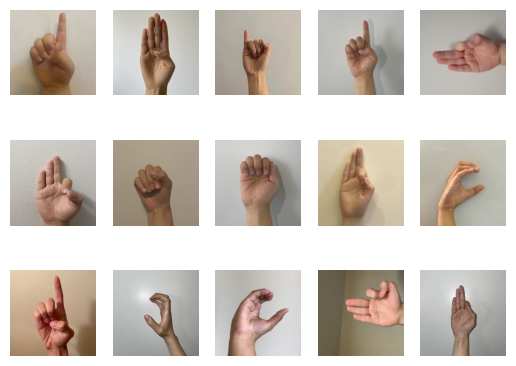

In [ ]:
#make sure that data loaded properly (modified code from lab 2)

import matplotlib.pyplot as plt

k = 0
for images, labels in train:
    # since batch_size = 1, there is only 1 image in `images`

    img = np.transpose(images, [0,1,2])
    # normalize pixel intensity values to [0, 1]
    img = img / 255.0
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    print(labels)

    k += 1
    if k > 14:
        break



### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In my network, I chose to create a simple CNN that features two convolutional layers to extract features and uses two fully-connected layers to classify the data. I chose to use a 3x3 kernel since in lecture we learned that higher dimension kernels are not any better at extracting features than 3x3s. Additionally, instead of using pooling layers, I used a stride of 3 to help consolidate the data. I used the relu activation function to achieve non-linearity and didn't have to worry about vanishing gradients too much due to the relatively small network. I also increased the number of channels from 3 to 5 to 10 through the convolutions to help the kernels identify more low level features.

In [ ]:
class ASLNet(nn.Module):
    def __init__(self):
        super(ASLNet, self).__init__()
        self.name="aslnet"
        self.conv1=nn.Conv2d(3, 5, 3, 2)
        self.conv2=nn.Conv2d(5, 10, 3, 2)
        self.fc1=nn.Linear(30250, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 30250)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
#Helps transform image data to tensors

class ASLDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
#Evaluate function from lab2 with some adjustments

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

#Model name function (lab 2) to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

My train function uses the multi-class cross entropy function nn.CrossEntropyLoss() as its loss function for two main reasons: there are multiple possible class outputs and it applies softsmax internally. This allows me to simply pass the unactivated final output of my neural network to the function and it will compute the softsmax and probabilities for each output on its own. For my optimizer I used optim.SGD which is stochastic gradient decent with momentum, this prevents the gradient from getting stuck in ravines and simply follows the gradient downward.

In [ ]:

def trainnet(net, batchsize, lr, epoch, train, val):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Comvert data to tensors and load the batches
    traindataset=ASLDataset(train, transform=transform)
    valdataset=ASLDataset(val, transform=transform)
    trainloader=torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader=torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    #set up error and loss array
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    #iterate through and train the data
    for epoch in range(epoch):
        total_train_samples=0
        i=0
        for image, label in trainloader:
            optimizer.zero_grad()
            output=net(image)
            loss=criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch]+=loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch] += (predicted != label).sum().item()
            total_train_samples+=len(label)
            i+=1
        #calculate error loss for each epoch
        train_loss[epoch]/=(i+1)
        train_error[epoch]/=total_train_samples
        #evaluate v=on validation for each epoch
        val_err[epoch], val_loss[epoch] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Train Error: {train_error[epoch]}, Val Loss: {val_loss[epoch]}, Val Error: {val_err[epoch]}")
        #checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch)
        torch.save(net.state_dict(), model_path)
    #save the model to plot later
    epochs = np.arange(1, epoch + 1)
    a=np.savetxt("{}_train_err.csv".format(model_path), train_error)
    b=np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    c=np.savetxt("{}_val_err.csv".format(model_path), val_err)
    d=np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
#extract a small dataset from our current one to overfit quickly and easily
small_train=train[:10]
small_val=val[:10]

In [ ]:
aslnet=ASLNet()

trainnet(aslnet, 10, 0.01, 50, small_train, small_val)

Epoch 1: Train Loss: 1.1436675786972046, Train Error: 0.7, Val Loss: 2.395826816558838, Val Error: 1.0
Epoch 2: Train Loss: 1.1345504522323608, Train Error: 0.7, Val Loss: 2.4161789417266846, Val Error: 1.0
Epoch 3: Train Loss: 1.1180498600006104, Train Error: 0.7, Val Loss: 2.4532604217529297, Val Error: 1.0
Epoch 4: Train Loss: 1.0978552103042603, Train Error: 0.7, Val Loss: 2.5115044116973877, Val Error: 1.0
Epoch 5: Train Loss: 1.0722907781600952, Train Error: 0.7, Val Loss: 2.60280179977417, Val Error: 1.0
Epoch 6: Train Loss: 1.043020486831665, Train Error: 0.7, Val Loss: 2.745619058609009, Val Error: 1.0
Epoch 7: Train Loss: 1.0147199630737305, Train Error: 0.7, Val Loss: 2.9444949626922607, Val Error: 1.0
Epoch 8: Train Loss: 0.9956971406936646, Train Error: 0.7, Val Loss: 3.116973400115967, Val Error: 1.0
Epoch 9: Train Loss: 0.9829319715499878, Train Error: 0.7, Val Loss: 3.122464179992676, Val Error: 1.0
Epoch 10: Train Loss: 0.9522638320922852, Train Error: 0.7, Val Loss: 2

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

The three hyperparemeters I will tune are:
    1. Stride Length
    2. Number of kernels and
    3. Batch Size
    

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

To fairly train each set of hyperparameters I will train each set to 30
 epochs.:

In [ ]:
#From lab2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
#Setting 1:
#Batch Size: 64, Stride Length: 2, Kernels: 5 first layer, 10 second layer

class ASLNet1(nn.Module):
    def __init__(self):
        super(ASLNet1, self).__init__()
        self.name="aslnet1"
        self.conv1=nn.Conv2d(3, 5, 3, 2)
        self.conv2=nn.Conv2d(5, 10, 3, 2)
        self.fc1=nn.Linear(30250, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 30250)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

aslnet1=ASLNet1()
trainnet(aslnet1, 64, 0.01, 30, train, val)

Epoch 1: Train Loss: 2.145938201384111, Train Error: 0.8728496634255797, Val Loss: 2.199409552982875, Val Error: 0.8139013452914798
Epoch 2: Train Loss: 1.8784090117974714, Train Error: 0.7120418848167539, Val Loss: 1.7848376205989294, Val Error: 0.6300448430493274
Epoch 3: Train Loss: 1.4729052077640186, Train Error: 0.5198204936424832, Val Loss: 1.3444854191371374, Val Error: 0.4551569506726457
Epoch 4: Train Loss: 1.2027451612732627, Train Error: 0.418848167539267, Val Loss: 1.3750438008989607, Val Error: 0.5067264573991032
Epoch 5: Train Loss: 1.0496774017810822, Train Error: 0.38967838444278236, Val Loss: 1.183909262929644, Val Error: 0.437219730941704
Epoch 6: Train Loss: 0.9097332927313718, Train Error: 0.3335826477187734, Val Loss: 1.1067271147455489, Val Error: 0.36995515695067266
Epoch 7: Train Loss: 0.7981783666393973, Train Error: 0.2954375467464473, Val Loss: 1.0067421538489205, Val Error: 0.336322869955157
Epoch 8: Train Loss: 0.7430839484388178, Train Error: 0.2655198204

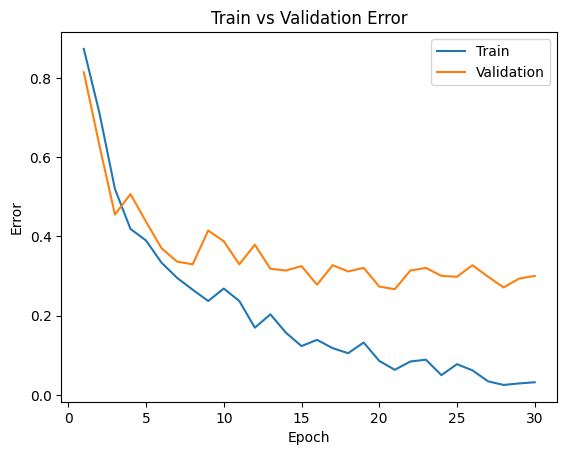

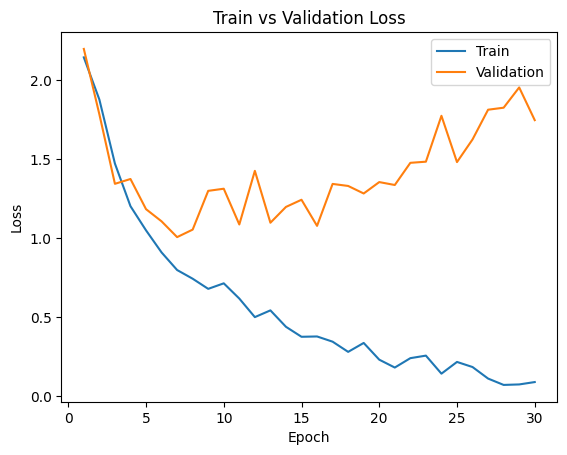

In [ ]:
model_path = get_model_name("aslnet1", batch_size=64, learning_rate=.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
#Setting 2:
#Batch Size: 128, Stride Length: 3, Kernels: 10 first layer, 20 second layer

class ASLNet2(nn.Module):
    def __init__(self):
        super(ASLNet2, self).__init__()
        self.name="aslnet2"
        self.conv1=nn.Conv2d(3, 10, 3, 3)
        self.conv2=nn.Conv2d(10, 20, 3, 3)
        self.fc1=nn.Linear(11520, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 11520)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

aslnet2=ASLNet2()
trainnet(aslnet2, 128, 0.01, 30, train, val)

Epoch 1: Train Loss: 2.1053583224614463, Train Error: 0.8908002991772626, Val Loss: 2.2887868881225586, Val Error: 0.8721973094170403
Epoch 2: Train Loss: 2.07676108678182, Train Error: 0.8893044128646223, Val Loss: 2.2424874901771545, Val Error: 0.8721973094170403
Epoch 3: Train Loss: 2.036077360312144, Train Error: 0.8646222887060584, Val Loss: 2.1869569420814514, Val Error: 0.8878923766816144
Epoch 4: Train Loss: 1.982865293820699, Train Error: 0.8219895287958116, Val Loss: 2.109059691429138, Val Error: 0.6300448430493274
Epoch 5: Train Loss: 1.8703474799791973, Train Error: 0.6896035901271503, Val Loss: 1.8585264682769775, Val Error: 0.6053811659192825
Epoch 6: Train Loss: 1.6464354296525319, Train Error: 0.6731488406881077, Val Loss: 1.5790399312973022, Val Error: 0.5650224215246636
Epoch 7: Train Loss: 1.41258704662323, Train Error: 0.5684367988032909, Val Loss: 1.531177967786789, Val Error: 0.57847533632287
Epoch 8: Train Loss: 1.2403377791245778, Train Error: 0.4809274495138369

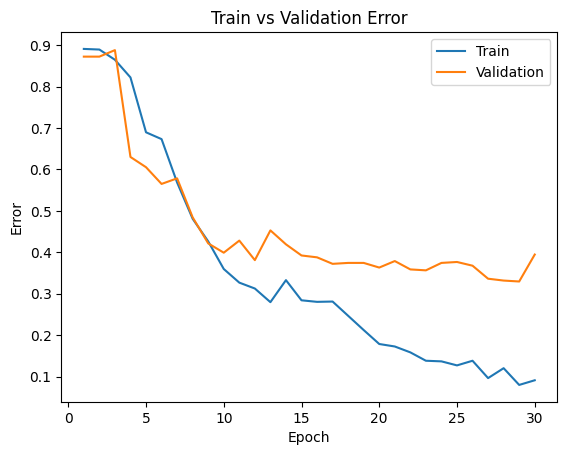

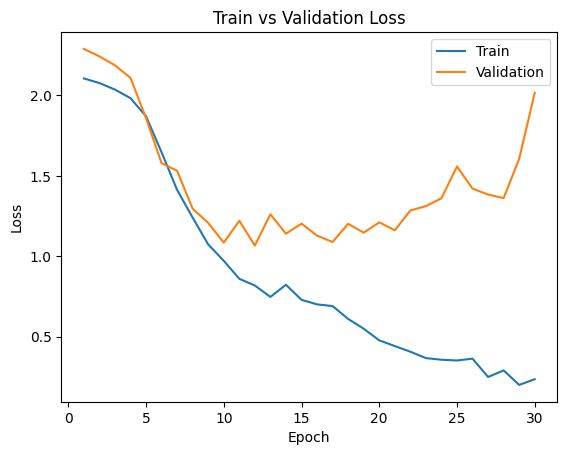

In [ ]:
model_path = get_model_name("aslnet2", batch_size=128, learning_rate=.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
#Setting 3: To offset the overfitting from 1 and still achieve good depth
#Batch Size: 32, Stride Length: 3, Kernels: 8 first layer, 24 second layer

class ASLNet3(nn.Module):
    def __init__(self):
        super(ASLNet3, self).__init__()
        self.name="aslnet3"
        self.conv1=nn.Conv2d(3, 8, 3, 3)
        self.conv2=nn.Conv2d(8, 24, 3, 3)
        self.fc1=nn.Linear(13824, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 13824)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

aslnet3=ASLNet3()
trainnet(aslnet3, 32, 0.01, 30, train, val)

Epoch 1: Train Loss: 2.204500054204187, Train Error: 0.8825729244577412, Val Loss: 2.1993327140808105, Val Error: 0.8789237668161435
Epoch 2: Train Loss: 1.9690823166869407, Train Error: 0.7569184741959611, Val Loss: 1.6129203013011388, Val Error: 0.5896860986547086
Epoch 3: Train Loss: 1.3898696428121522, Train Error: 0.5198204936424832, Val Loss: 1.3064666134970528, Val Error: 0.5112107623318386
Epoch 4: Train Loss: 1.1546212559522584, Train Error: 0.4397905759162304, Val Loss: 1.1514358222484589, Val Error: 0.45067264573991034
Epoch 5: Train Loss: 0.9799105968586234, Train Error: 0.35153328347045626, Val Loss: 0.9612977100270135, Val Error: 0.33183856502242154
Epoch 6: Train Loss: 0.8810280090154603, Train Error: 0.3156320119670905, Val Loss: 1.1081535858767373, Val Error: 0.3721973094170404
Epoch 7: Train Loss: 0.7931357871654422, Train Error: 0.299925205684368, Val Loss: 1.0911394272531783, Val Error: 0.34080717488789236
Epoch 8: Train Loss: 0.6893007554287134, Train Error: 0.2520

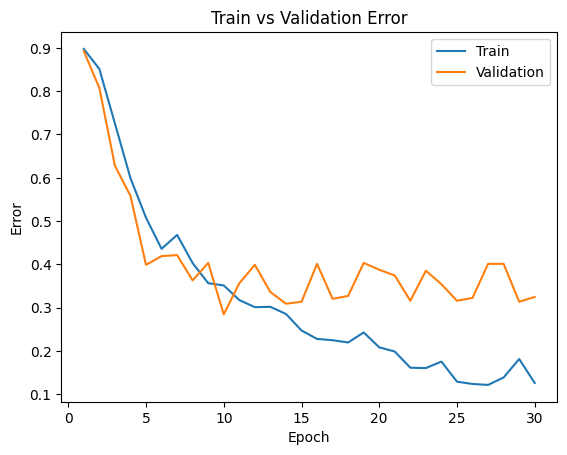

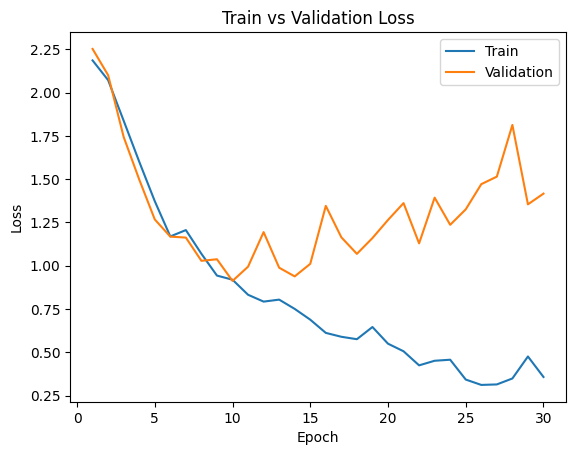

In [ ]:
model_path = get_model_name("aslnet3", batch_size=64, learning_rate=.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
#Setting 3
#Batch Size: 64, Stride Length: 3, Kernels: 6 first layer, 12 second layer

class ASLNet4(nn.Module):
    def __init__(self):
        super(ASLNet4, self).__init__()
        self.name="aslnet4"
        self.conv1=nn.Conv2d(3, 6, 3, 3)
        self.conv2=nn.Conv2d(6, 12, 3, 3)
        self.fc1=nn.Linear(6912, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 6912)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

aslnet4=ASLNet4()
trainnet(aslnet4, 64, 0.01, 30, train, val)

Epoch 1: Train Loss: 2.181618712165139, Train Error: 0.8863126402393419, Val Loss: 2.247022867202759, Val Error: 0.8295964125560538
Epoch 2: Train Loss: 2.0972441868348555, Train Error: 0.8773373223635004, Val Loss: 2.144745009286063, Val Error: 0.9013452914798207
Epoch 3: Train Loss: 1.9170211065899243, Train Error: 0.762902019446522, Val Loss: 1.8011774505887712, Val Error: 0.726457399103139
Epoch 4: Train Loss: 1.515444126996127, Train Error: 0.6013462976813763, Val Loss: 1.441994036946978, Val Error: 0.5627802690582959
Epoch 5: Train Loss: 1.2070996544577859, Train Error: 0.4682124158563949, Val Loss: 1.1859194125447954, Val Error: 0.4125560538116592
Epoch 6: Train Loss: 1.0960530801252886, Train Error: 0.41660433807030667, Val Loss: 1.1228632416043962, Val Error: 0.4013452914798206
Epoch 7: Train Loss: 0.9858288385651328, Train Error: 0.38219895287958117, Val Loss: 1.0266155345099313, Val Error: 0.3654708520179372
Epoch 8: Train Loss: 0.8925946734168313, Train Error: 0.33208676140

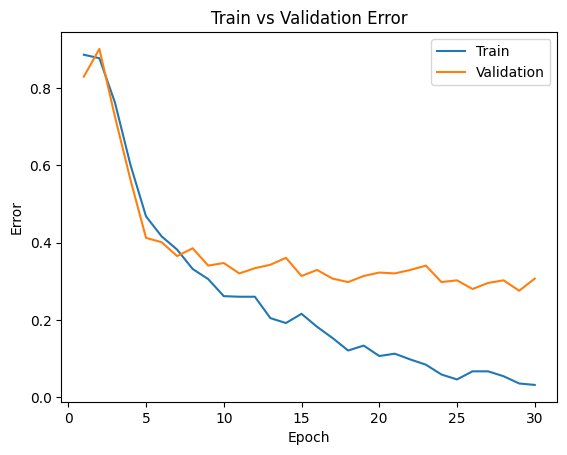

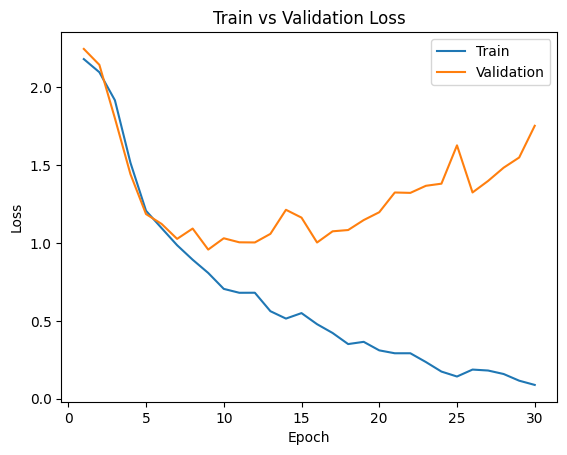

In [ ]:
model_path = get_model_name("aslnet4", batch_size=64, learning_rate=.01, epoch=29)
plot_training_curve(model_path)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best model out of my previous settings is ASLNet3 which achieved the lowest validation error and did not demonstrate intense overfitting to the training data. Since the network is not trained on validation data and it is seen much less than the training data, I used it to evaluate which model is the best fit. In the real world, the model won't be reacting to data that it trained on so validation is a better way to adjudicate the model than training.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testdataset=ASLDataset(test, transform=transform)
testloader=torch.utils.data.DataLoader(testdataset, batch_size=64, shuffle=True)

testerror, testloss=evaluate(aslnet3, testloader, nn.CrossEntropyLoss())
print(f"Test Error: {testerror}")
print(f"Test Loss: {testloss}")

Test Error: 0.24439461883408073
Test Loss: 1.9002973181860787


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
"""img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)"""

'img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...\nfeatures = alexnet.features(img)'

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
featuretrain=train
for img, lables in featuretrain:
  img=transforms.ToTensor()(img)
  img=alexnet.features(img)
  img=img.detach().numpy()
  img=torch.from_numpy(img)

featurevalid=val
for img, lables in featurevalid:
  img=transforms.ToTensor()(img)
  img=alexnet.features(img)
  img=img.detach().numpy()
  img=torch.from_numpy(img)

featuretest=test
for img, lables in featuretest:
  img=transforms.ToTensor()(img)
  img=alexnet.features(img)
  img=img.detach().numpy()
  img=torch.from_numpy(img)


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?



In order to obtain a true idea of transfer learning's ability, I will utilise a similar network as in the previous parts featuring two convolutional layers and two fully-connected layers. Similarly to before the two convolutional layers will be used to extract some features from the alexnet data and then the fully-connected layers will be used to classify the data. Again I will use the relu activation function to introduce non-linearity and stride lengths greater than 1 to consolidate the data. I will also use 3x3 kernels and tune their depth as a hyperparameter.

In [ ]:
class AlexASLNet(nn.Module):
    def __init__(self):
        super(AlexASLNet, self).__init__()
        self.name="alexaslnet"
        self.conv1=nn.Conv2d(3, 5, 3, 2)
        self.conv2=nn.Conv2d(5, 10, 3, 2)
        self.fc1=nn.Linear(30250, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 30250)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

To maintain consistency between the transfer learning model and the original model, I will tune the hyperparameters in a similar way by training for 30 epochs, looking for instances of over or underfitting and then adjusting the batch size, kernel channels, and stride length accordingly.

In [ ]:
#Completed in data loading
"""tensor = torch.from_numpy(tensor.detach().numpy())"""

'tensor = torch.from_numpy(tensor.detach().numpy())'

In [ ]:
Alexaslnet=AlexASLNet()
trainnet(Alexaslnet, 64, 0.01, 30, featuretrain, featurevalid)

Epoch 1: Train Loss: 2.189438570629467, Train Error: 0.8878085265519821, Val Loss: 2.2643513679504395, Val Error: 0.9035874439461884
Epoch 2: Train Loss: 2.120827490633184, Train Error: 0.8526551982049364, Val Loss: 2.147437947137015, Val Error: 0.7466367713004485
Epoch 3: Train Loss: 1.8430536443536931, Train Error: 0.7135377711293942, Val Loss: 1.6033146381378174, Val Error: 0.6076233183856502
Epoch 4: Train Loss: 1.3685132698579268, Train Error: 0.48840688107703817, Val Loss: 1.3416673796517509, Val Error: 0.4820627802690583
Epoch 5: Train Loss: 1.0874193825504996, Train Error: 0.3986537023186238, Val Loss: 1.147964290210179, Val Error: 0.40358744394618834
Epoch 6: Train Loss: 1.0075975141742013, Train Error: 0.39267015706806285, Val Loss: 1.099649293082101, Val Error: 0.3654708520179372
Epoch 7: Train Loss: 0.9169964492321014, Train Error: 0.3403141361256545, Val Loss: 1.162621557712555, Val Error: 0.4461883408071749
Epoch 8: Train Loss: 0.7992636913603003, Train Error: 0.285714285

In [ ]:
class AlexASLNet2(nn.Module):
    def __init__(self):
        super(AlexASLNet2, self).__init__()
        self.name="alexaslnet2"
        self.conv1=nn.Conv2d(3, 9, 3, 2)
        self.conv2=nn.Conv2d(9, 18, 3, 2)
        self.fc1=nn.Linear(54450, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 54450)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

alexaslnet2=AlexASLNet2()
trainnet(alexaslnet2, 32, 0.01, 30, featuretrain, featurevalid)

Epoch 1: Train Loss: 2.0277397992999053, Train Error: 0.7816005983545251, Val Loss: 1.7813417230333601, Val Error: 0.7197309417040358
Epoch 2: Train Loss: 1.3960903661195623, Train Error: 0.512341062079282, Val Loss: 1.2092195366110121, Val Error: 0.42376681614349776
Epoch 3: Train Loss: 1.0824685997741168, Train Error: 0.3994016454749439, Val Loss: 1.096258018698011, Val Error: 0.3789237668161435
Epoch 4: Train Loss: 0.9259421326393305, Train Error: 0.33208676140613314, Val Loss: 1.124304371220725, Val Error: 0.37668161434977576
Epoch 5: Train Loss: 0.8368962199188942, Train Error: 0.3081525804038893, Val Loss: 1.3176162242889404, Val Error: 0.4147982062780269
Epoch 6: Train Loss: 0.7503064919349759, Train Error: 0.268511593118923, Val Loss: 1.0029021160943168, Val Error: 0.3295964125560538
Epoch 7: Train Loss: 0.6815883371719095, Train Error: 0.24906507105459985, Val Loss: 1.579503561769213, Val Error: 0.4349775784753363
Epoch 8: Train Loss: 0.6830089355623999, Train Error: 0.2363500

In [ ]:
class AlexASLNet3(nn.Module):
    def __init__(self):
        super(AlexASLNet3, self).__init__()
        self.name="alexaslnet3"
        self.conv1=nn.Conv2d(3, 10, 3, 3)
        self.conv2=nn.Conv2d(10, 20, 3, 3)
        self.fc1=nn.Linear(11520, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 11520)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

alexaslnet3=AlexASLNet3()
trainnet(alexaslnet3, 32, 0.01, 30, featuretrain, featurevalid)

Epoch 1: Train Loss: 2.177436440490013, Train Error: 0.8848167539267016, Val Loss: 2.080078133514949, Val Error: 0.8340807174887892
Epoch 2: Train Loss: 1.704974507176599, Train Error: 0.6350037397157816, Val Loss: 1.3880340712411063, Val Error: 0.49327354260089684
Epoch 3: Train Loss: 1.2374557533929513, Train Error: 0.43904263275991023, Val Loss: 1.2761915411267961, Val Error: 0.45964125560538116
Epoch 4: Train Loss: 1.0846395714338435, Train Error: 0.406133133881825, Val Loss: 1.1783762403896876, Val Error: 0.42152466367713004
Epoch 5: Train Loss: 0.949287400689236, Train Error: 0.3462976813762154, Val Loss: 1.1139787903853826, Val Error: 0.3834080717488789
Epoch 6: Train Loss: 0.8490887034771054, Train Error: 0.318623784592371, Val Loss: 0.9801245033740997, Val Error: 0.3273542600896861
Epoch 7: Train Loss: 0.7591249388317729, Train Error: 0.2924457741211668, Val Loss: 0.9853097455842155, Val Error: 0.32062780269058294
Epoch 8: Train Loss: 0.6981044834436372, Train Error: 0.2685115

In [ ]:
class AlexASLNet4(nn.Module):
    def __init__(self):
        super(AlexASLNet4, self).__init__()
        self.name="alexaslnet4"
        self.conv1=nn.Conv2d(3, 8, 3, 3)
        self.conv2=nn.Conv2d(8, 24, 3, 3)
        self.fc1=nn.Linear(13824, 32)
        self.fc2=nn.Linear(32,10)
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=x.view(-1, 13824)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

alexaslnet4=AlexASLNet4()
trainnet(alexaslnet4, 16, 0.01, 30, featuretrain, featurevalid)

Epoch 1: Train Loss: 2.148713329259087, Train Error: 0.8302169035153328, Val Loss: 1.697526833840779, Val Error: 0.6457399103139013
Epoch 2: Train Loss: 1.45806287316715, Train Error: 0.5235602094240838, Val Loss: 1.2707829305103846, Val Error: 0.452914798206278
Epoch 3: Train Loss: 1.1894247118164512, Train Error: 0.4323111443530292, Val Loss: 1.2607295236417226, Val Error: 0.43946188340807174
Epoch 4: Train Loss: 0.9949440240859986, Train Error: 0.3582647718773373, Val Loss: 1.0812873797757285, Val Error: 0.36771300448430494
Epoch 5: Train Loss: 0.8538346402785357, Train Error: 0.3156320119670905, Val Loss: 0.9562876942966666, Val Error: 0.3452914798206278
Epoch 6: Train Loss: 0.7213786558193319, Train Error: 0.268511593118923, Val Loss: 0.932675259986094, Val Error: 0.2802690582959641
Epoch 7: Train Loss: 0.7222610852297615, Train Error: 0.24607329842931938, Val Loss: 1.2157394960522652, Val Error: 0.3834080717488789
Epoch 8: Train Loss: 0.5982493814300088, Train Error: 0.2363500373

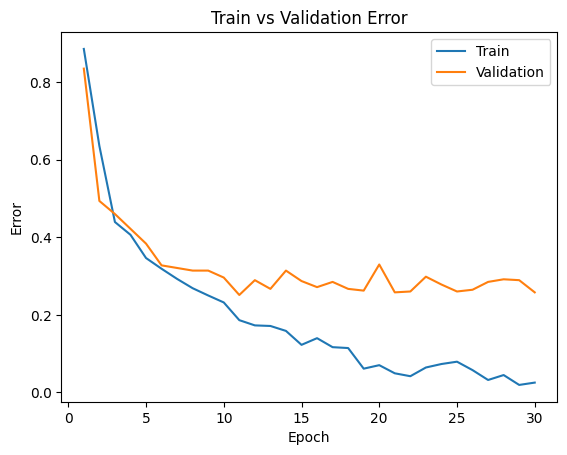

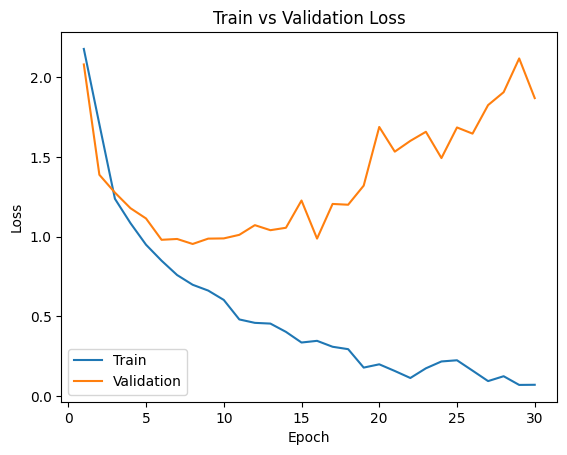

In [ ]:
#Best Model is AlexASLNet3, similar val error to others with less overfitting
model_path = get_model_name("alexaslnet3", batch_size=32, learning_rate=.01, epoch=29)
plot_training_curve(model_path)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
featuretestdataset=ASLDataset(featuretest, transform=transform)
featuretestloader=torch.utils.data.DataLoader(featuretestdataset, batch_size=64, shuffle=True)

featuretesterror, featuretestloss=evaluate(alexaslnet3, featuretestloader, nn.CrossEntropyLoss())
print(f"Test Error: {featuretesterror}")
print(f"Test Loss: {featuretestloss}")

Test Error: 0.22869955156950672
Test Loss: 1.4145798512867518


In [ ]:
print(f"Accuracy without Transfer Learning: {1-testerror}")
print(f"Accuracy with Transfer Learning: {1-featuretesterror}")

Accuracy without Transfer Learning: 0.7556053811659192
Accuracy with Transfer Learning: 0.7713004484304933


The accuracy with transfer learning is slightly better than the accuracy without, however from observing the the error epoch by epoch the transfer learning model trains much faster than the other model. This led in a couple cases to overfitting or the training error dropping quickly, despite this the transfer learning accuracy still managed to be higher than the accuracy without transfer learning.